In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader import data
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
assets = ["JBSS3.SA", "VALE3.SA", "PETR4.SA", "BBDC4.SA"]

### Functions

 1. get_returns() - inputs: a list with the ticks of the assets in yahoo finance, and the desired start and end date. This function has as it's output a dataframe with the assets returns. 

In [3]:
def get_returns(asset_list, startdate, enddate):
    
    assets_data = pd.DataFrame()

    for i in asset_list:
        temporary = data.DataReader(i, data_source = "yahoo", 
                                     start = startdate, end = enddate)

        temporary.rename(columns = {"Adj Close":i}, inplace = True)
        temporary = temporary.drop(temporary.columns[[0,1,2,3,4]], axis=1)
        temporary = temporary.pct_change()
        temporary = temporary.drop(temporary.index[0])
        assets_data[i] = temporary
        
    return assets_data

### 1) Getting returns

In [4]:
returns = get_returns(asset_list=assets,
             startdate="2010-01-01", enddate="2022-01-01")

returns

,JBSS3.SA,VALE3.SA,PETR4.SA,BBDC4.SA
Date,,,,
2010-01-05,-0.009307,0.009322,-0.008574,-0.004956
2010-01-06,0.015657,0.021166,0.013513,-0.008000
2010-01-07,0.022611,0.004145,-0.009333,-0.002688
2010-01-08,0.001005,0.009758,-0.005384,-0.001078
2010-01-11,-0.015060,-0.002973,-0.003248,0.000810
...,...,...,...,...
2021-12-23,0.012346,-0.009635,0.006037,0.003128
2021-12-27,-0.006628,-0.002527,0.014825,0.011434
2021-12-28,0.011209,-0.024066,0.001044,-0.003597


### 2) Plotting distribuitions (looking for a normal distribution)

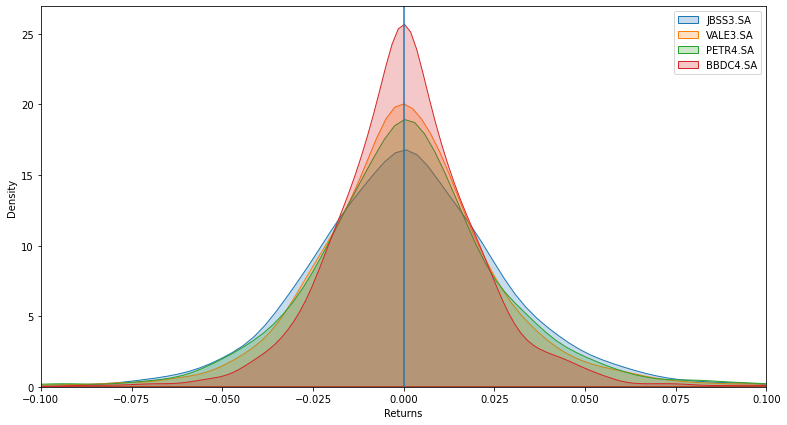

In [5]:
plt.figure(figsize=(13,7))

for i in assets:
    fig = sns.kdeplot(returns[i], shade=True, label=i)

plt.xlabel("Returns")
plt.xlim([-0.10, 0.10])
plt.axvline(0)
plt.legend()
plt.show()

### 3) Statistically testing with Jarque-Bera

p-value smaller than que 0.05 = not normally distributed  <br>
p-vaue bigger than 0.05 = normally distributed

In [6]:
for i in assets:
    print(f"Test result for {i}: {stats.jarque_bera(returns[i])}")

Test result for JBSS3.SA: Jarque_beraResult(statistic=12368.089846313293, pvalue=0.0)
Test result for VALE3.SA: Jarque_beraResult(statistic=6326.615719724296, pvalue=0.0)
Test result for PETR4.SA: Jarque_beraResult(statistic=10360.044826233281, pvalue=0.0)
Test result for BBDC4.SA: Jarque_beraResult(statistic=6099.872823370173, pvalue=0.0)


### Conclusion

Contradicting what could be possibly assumed just by looking at the visual graphic representation, JB tests shows that none of the given returns series were statistically considered normally distributed.

<br>

### Extra: Risk x Return Matrix

Annualized Volatilities:

In [7]:
volatility = pd.DataFrame()
root_252 = np.power(252,1/2)

for i in assets:
    volatility[i] = [returns[i].std()*root_252]

volatility

,JBSS3.SA,VALE3.SA,PETR4.SA,BBDC4.SA
0,0.478038,0.417548,0.465711,0.344761


Anualized Returns:

In [8]:
cumulative_ret = (returns + 1).cumprod()
cumulative_ret = cumulative_ret.iloc[-1,:]
annualized_ret = (cumulative_ret**(1/(returns.shape[0]/252)))-1
annualized_ret = annualized_ret.to_frame()
annualized_ret.columns = ["Ann_Returns"]

annualized_ret

,Ann_Returns
JBSS3.SA,0.144920
VALE3.SA,0.088986
PETR4.SA,0.015804
BBDC4.SA,0.053898


Merging both dataframes:

In [9]:
volatility_and_returns = annualized_ret
volatility_and_returns["Ann_Vol"] = volatility.iloc[0,:]

volatility_and_returns

,Ann_Returns,Ann_Vol
JBSS3.SA,0.144920,0.478038
VALE3.SA,0.088986,0.417548
PETR4.SA,0.015804,0.465711
BBDC4.SA,0.053898,0.344761


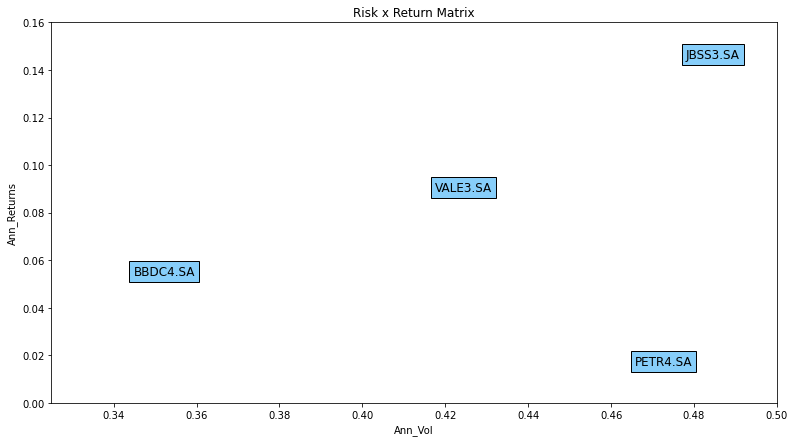

In [10]:
plt.figure(figsize=(13,7))
plt.xlim([0.325, 0.50])
plt.ylim([0, 0.16])
plt.title("Risk x Return Matrix")

sns.scatterplot(data=volatility_and_returns, x="Ann_Vol", y="Ann_Returns")
for i in range(0, volatility_and_returns.shape[0]):
    plt.text(x=volatility_and_returns.Ann_Vol[i], y=volatility_and_returns.Ann_Returns[i], 
             s=volatility_and_returns.index[i], fontsize=12, color="black", bbox=dict(facecolor="lightskyblue")
             )

plt.show()